In [1]:
from dotenv import load_dotenv
import os
import pandas as pd
from pyoso import Client

load_dotenv()
OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

## Explore project and collection sources available in OSO

### High-level overview of projects by collection

In [2]:
client.to_pandas("""
SELECT
  collection_source,
  collection_namespace,
  COUNT(DISTINCT collection_name) AS num_collections,
  COUNT(DISTINCT project_name) AS num_projects
FROM projects_by_collection_v1
GROUP BY 1,2
ORDER BY 1,2
""")

,collection_source,collection_namespace,num_collections,num_projects
0,DEFILLAMA,protocol_metadata,83,5303
1,OPENLABELSINITIATIVE,usage_category,34,506
2,OP_ATLAS,retro-funding,12,559
3,OSS_DIRECTORY,oso,54,3834


### High-level overview of artifacts by project

In [3]:
client.to_pandas("""
SELECT
  project_source,
  project_namespace,
  COUNT(DISTINCT project_name) AS num_projects,
  COUNT(DISTINCT artifact_source) AS num_artifact_sources
FROM artifacts_by_project_v1
GROUP BY 1,2
ORDER BY 1,2
""")

,project_source,project_namespace,num_projects,num_artifact_sources
0,CRYPTO_ECOSYSTEMS,branch,4595,1
1,CRYPTO_ECOSYSTEMS,eco,7265,1
2,DEFILLAMA,protocol_metadata,5303,1
3,OPENLABELSINITIATIVE,owner_project,512,18
4,OP_ATLAS,,3660,35
5,OSS_DIRECTORY,oso,5400,43


## Explore metrics for new project and collection sources

### Crypto Ecosystems (GitHub data)

In [4]:
client.to_pandas("""
SELECT *
FROM projects_v1
WHERE
  project_name = 'ethereum'
  AND project_source = 'CRYPTO_ECOSYSTEMS'
  AND project_namespace = 'eco'
""")

,project_id,project_source,project_namespace,project_name,display_name,description
0,ihCJZRA5hySMDdhvv9ihmzf6B+bTAps1Z+U+vxNqLgs=,CRYPTO_ECOSYSTEMS,eco,ethereum,Ethereum,None


In [5]:
client.to_pandas("""
SELECT metric_name
FROM metrics_v0
WHERE
  metric_name LIKE 'GITHUB%'
  AND metric_name LIKE '%weekly'
ORDER BY 1
""")

,metric_name
0,GITHUB_bot_activity_weekly
1,GITHUB_burstiness_weekly
2,GITHUB_closed_issues_weekly
3,GITHUB_comments_weekly
4,GITHUB_commits_weekly
5,GITHUB_contributor_absence_factor_weekly
6,GITHUB_contributors_weekly
7,GITHUB_forks_weekly
8,GITHUB_issue_age_avg_weekly
9,GITHUB_issue_age_max_weekly


In [6]:
client.to_pandas("""
SELECT
  sample_date,
  amount
FROM timeseries_metrics_by_project_v0
JOIN metrics_v0 USING metric_id
JOIN projects_v1 USING project_id
WHERE
  metric_name = 'GITHUB_contributors_weekly'
  AND project_name = 'ethereum'
  AND project_source = 'CRYPTO_ECOSYSTEMS'
  AND project_namespace = 'eco'
ORDER BY 1
""")

,sample_date,amount
0,2025-07-14,2718
1,2025-07-21,2650
2,2025-07-28,2535
3,2025-08-04,2402
4,2025-08-11,2434


In [7]:
client.to_pandas("""
SELECT
  sample_date,
  amount
FROM timeseries_metrics_by_project_v0
JOIN metrics_v0 USING metric_id
JOIN projects_v1 USING project_id
WHERE
  metric_name = 'GITHUB_project_velocity_weekly'
  AND project_name = 'ethereum'
  AND project_source = 'CRYPTO_ECOSYSTEMS'
  AND project_namespace = 'eco'
ORDER BY 1
""")

,sample_date,amount
0,2025-07-14,51134
1,2025-07-21,49691
2,2025-07-28,50369
3,2025-08-04,47292
4,2025-08-11,47702


<Axes: xlabel='sample_date'>

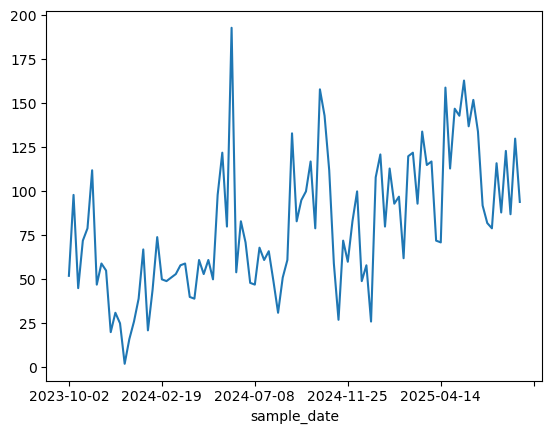

In [8]:
df = client.to_pandas("""
SELECT
  sample_date,
  amount
FROM timeseries_metrics_by_project_v0
JOIN metrics_v0 USING metric_id
JOIN projects_v1 USING project_id
WHERE
  metric_name = 'GITHUB_project_velocity_weekly'
  AND project_name = 'opensource-observer'
  AND project_source = 'OSS_DIRECTORY'
ORDER BY 1
""")
df.set_index('sample_date')['amount'].plot()

### OpenLabelsInitiative (labeled blockchain data)

In [9]:
client.to_pandas("""
SELECT
  collection_name,
  COUNT(DISTINCT project_id) AS num_projects
FROM projects_by_collection_v1
WHERE collection_source = 'OPENLABELSINITIATIVE'
GROUP BY 1
""")

,collection_name,num_projects
0,cex,8
1,airdrop,64
2,non_fungible_tokens,61
3,native_transfer,3
4,trading,5
5,nft_marketplace,13
6,gambling,4
7,custody,1
8,middleware,1
9,staking,46


In [10]:
client.to_pandas("""
SELECT
  sample_date,
  SUM(CASE WHEN collection_name = 'mev' THEN amount ELSE 0 end) AS mev_gas_fees,
  SUM(CASE WHEN collection_name = 'dex' THEN amount ELSE 0 end) AS dex_gas_fees
FROM timeseries_metrics_by_collection_v0
JOIN metrics_v0 USING metric_id
JOIN collections_v1 USING collection_id
WHERE
  metric_name = 'BASE_gas_fees_weekly'
  AND collection_name IN ('mev', 'dex')
  AND collection_source = 'OPENLABELSINITIATIVE'
GROUP BY 1
ORDER BY 1
""")

,sample_date,mev_gas_fees,dex_gas_fees
0,2025-07-14,170.98781,405.440417
1,2025-07-21,257.458796,473.830629
2,2025-07-28,296.780919,553.806334
3,2025-08-04,287.761356,480.388941
4,2025-08-11,499.189875,780.52156


### DefiLlama (TVL categories)

In [11]:
client.to_pandas("""
SELECT
  collection_name,
  COUNT(DISTINCT project_id) AS num_projects
FROM projects_by_collection_v1
WHERE collection_source = 'DEFILLAMA'
GROUP BY 1
""")

,collection_name,num_projects
0,dexs,1479
1,risk_curators,25
2,yield,551
3,staking_pool,41
4,restaking,14
...,...,...
78,decentralized_btc,5
79,liquidations,2
80,nftfi,3
81,cedefi,4


In [12]:
client.to_pandas("""
SELECT
  collection_name AS category,
  SUM(ROUND(amount / 1000000)) AS total_tvl_for_category_millions
FROM timeseries_metrics_by_collection_v0
JOIN metrics_v0 USING metric_id
JOIN collections_v1 USING collection_id
WHERE
  metric_name = 'BASE_defillama_tvl_daily'
  AND collection_source = 'DEFILLAMA'
  AND sample_date = DATE('2025-08-05')
GROUP BY 1
ORDER BY 2 DESC
""")

,category,total_tvl_for_category_millions
0,lending,3549
1,dexs,1245
2,onchain_capital_allocator,1075
3,yield_aggregator,247
4,yield,135
5,derivatives,104
6,leveraged_farming,79
7,cdp,60
8,token_locker,42
9,options,40
